In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

%matplotlib inline

Data Loading

In [2]:
hr = pd.read_csv('turnover.csv')

#Explore analysis
hr.info()
hr.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [3]:
# Missing data checking
hr.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [4]:
# List values of categorical columns
categories = {'sales': hr['sales'].unique().tolist(), 'salary': hr['salary'].unique().tolist()}
for i in sorted(categories.keys()):
    print(i+":")
    print(categories[i])
    if i != sorted(categories.keys())[-1]:
        print('\n')

salary:
['low', 'medium', 'high']


sales:
['sales', 'accounting', 'hr', 'technical', 'support', 'management', 'IT', 'product_mng', 'marketing', 'RandD']


In [5]:
# Rename sales column
hr = hr.rename(columns={'sales': 'Department'})
hr = hr.rename(columns={'average_montly_hours': 'average_monthly_hours'})
hr.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
# Target proportion
hr['left'].value_counts()

0    11428
1     3571
Name: left, dtype: int64

In [7]:
# Get the mean of each variable for employees who left
hr.groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


Employees who left company have
Lower satisfaction_level: 0.44 vs 0.67
Higher average_monthly_hours: 207 vs 199
Lower work_accident: 0.05 vs 0.18
Lower promotion_last_5years: 0.01 vs 0.03

Correlation Analysis

Correlation analysis will allow to identify the relationship between dataset variables. A plot of this distribution highlighting the value of target variable can also reveal some patterns.

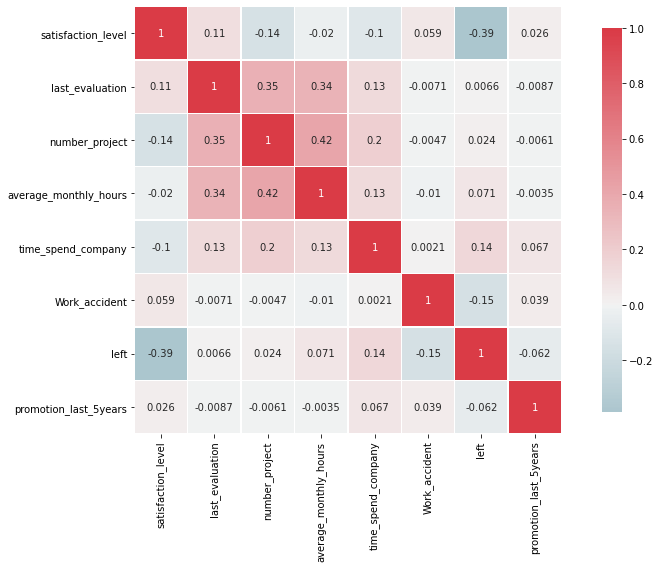

In [8]:
# Correlation matrix
plt.figure(figsize=(12,8))

# Generate a mask for the upper triangle
mask = np.zeros_like(hr.corr(), dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(hr.corr(), cmap=cmap, annot=True, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .9})
plt.tight_layout()

number_project has moderate positive correlation with average_monthly_hours 0.42;   
number_project has moderate positive correlation with last_evaluation 0.35;   
average_monthly_hours has moderate positive correlation with last_evaluation 0.33;
left has moderate negative correlation with satisfaction_level -0.39

Explantory Visualization

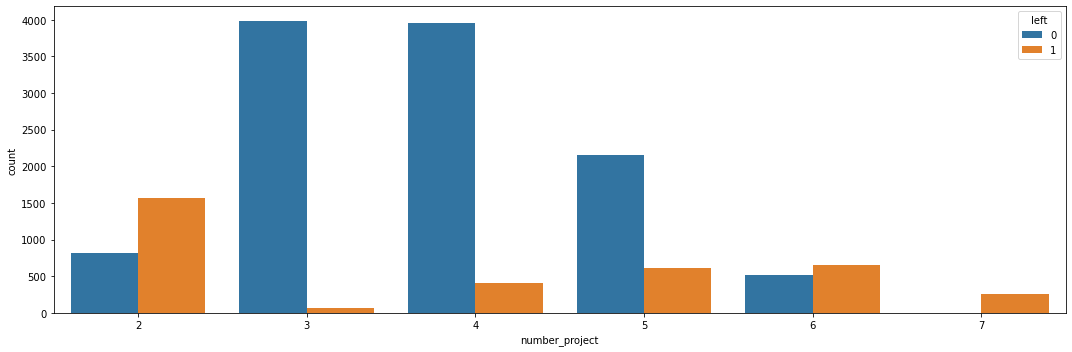

In [9]:
# Turnover by number of projects
plt.figure(figsize=(15,5))
sns.countplot(x='number_project', hue='left', data=hr)
plt.tight_layout()

Employees with only 2 or more than 5 projects have a higher probality to leave the company.

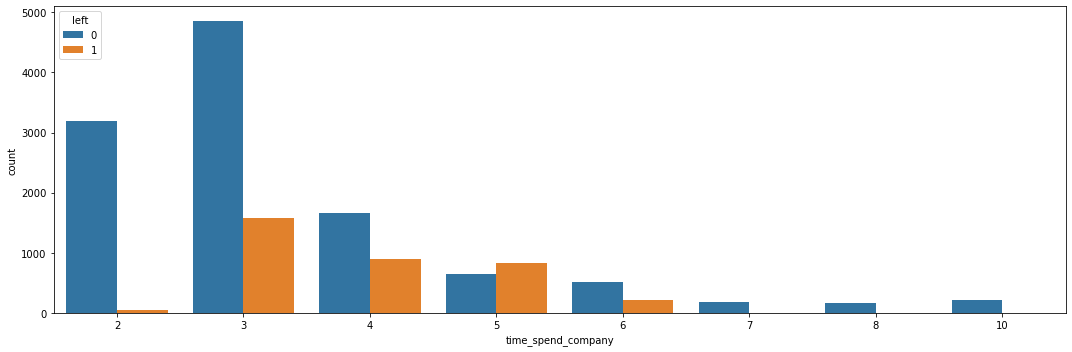

In [10]:
# Turnover by time spend in company
plt.figure(figsize=(15,5))
sns.countplot(x='time_spend_company', hue='left', data=hr)
plt.tight_layout()

Employess with 3-6 years of services are leaving company.

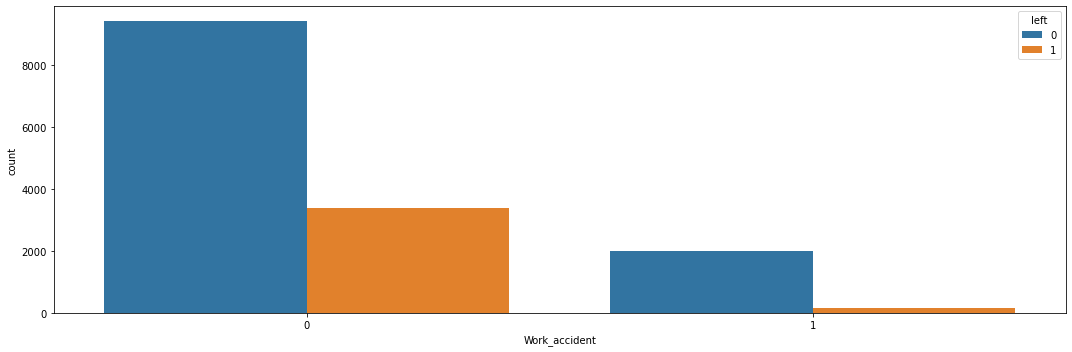

In [11]:
# Turnover by work accident
plt.figure(figsize=(15,5))
sns.countplot(x='Work_accident', hue='left', data=hr)
plt.tight_layout()

Employees without a work accident tend to leave company.

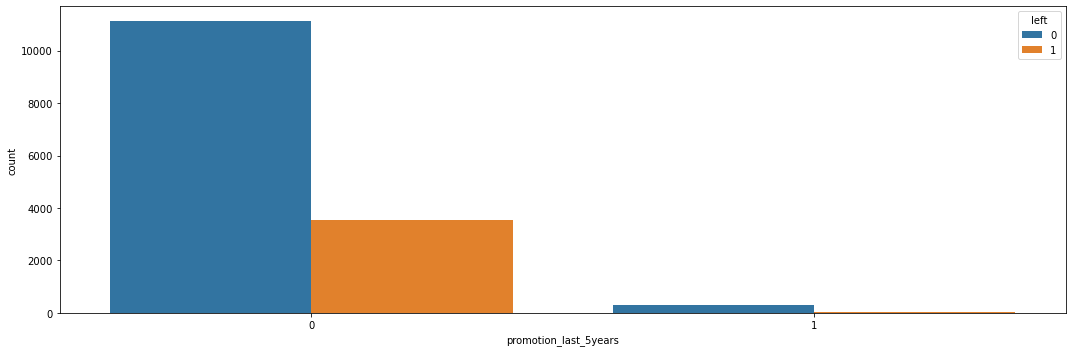

In [12]:
# Turnover by promotion in last 5 years
plt.figure(figsize=(15,5))
sns.countplot(x='promotion_last_5years', hue='left', data=hr)
plt.tight_layout()

In [13]:
print('Turnover Rate if Promotion:', round(len(hr[(hr['promotion_last_5years']==1)&(hr['left']==1)])/len(hr[(hr['promotion_last_5years']==1)])*100,2),'%')
print('Turnover Rate if No Promotion:', round(len(hr[(hr['promotion_last_5years']==0)&(hr['left']==1)])/len(hr[(hr['promotion_last_5years']==0)])*100,2),'%')

Turnover Rate if Promotion: 5.96 %
Turnover Rate if No Promotion: 24.2 %


Employees without promotion in the last 5 years have more propensity to leave.

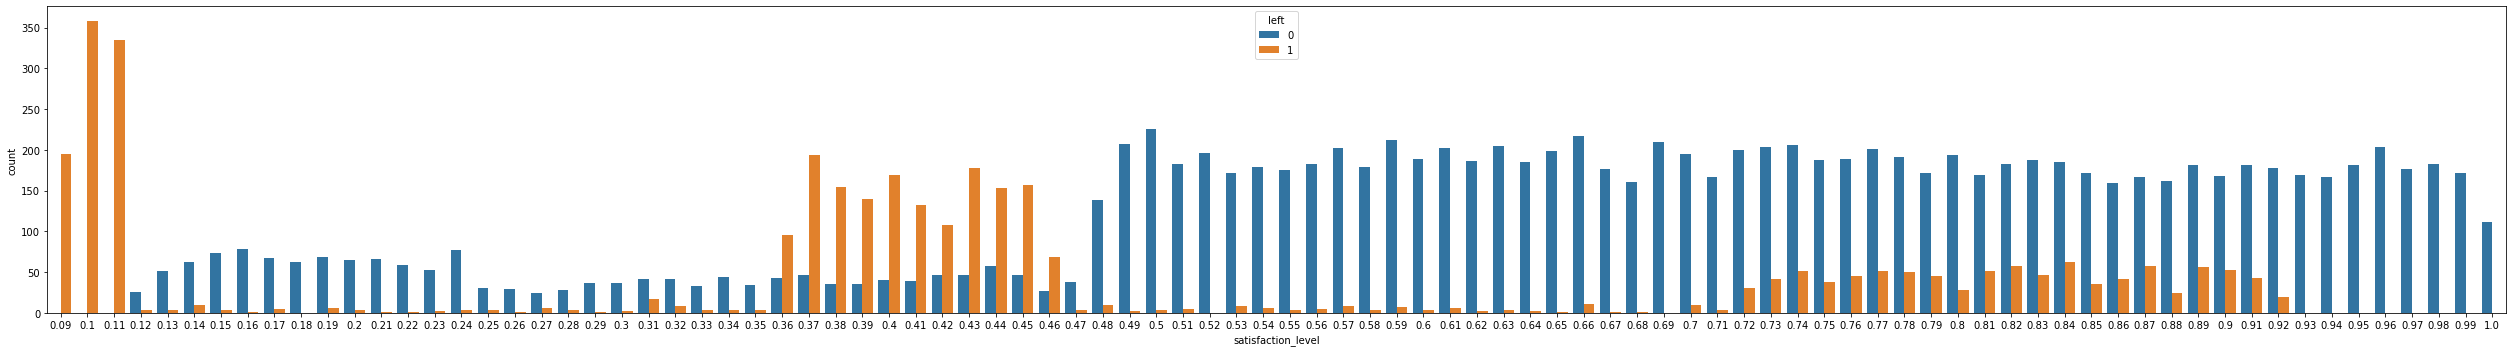

In [14]:
# Turnover by satisfaction level
plt.figure(figsize=(35,5))
sns.countplot(x='satisfaction_level', hue='left', data=hr)
plt.tight_layout()

Employees who left company have satisfaction level at 0.09-0.12, 0.36-0.46, 0.72-0.92 regions. In most of cases, lower satisfaction level leads to high turnover count. The risky zone is when employee evaluate their satifaction level below 0.5. Employees also tend to leave when they become moderately satisfied.

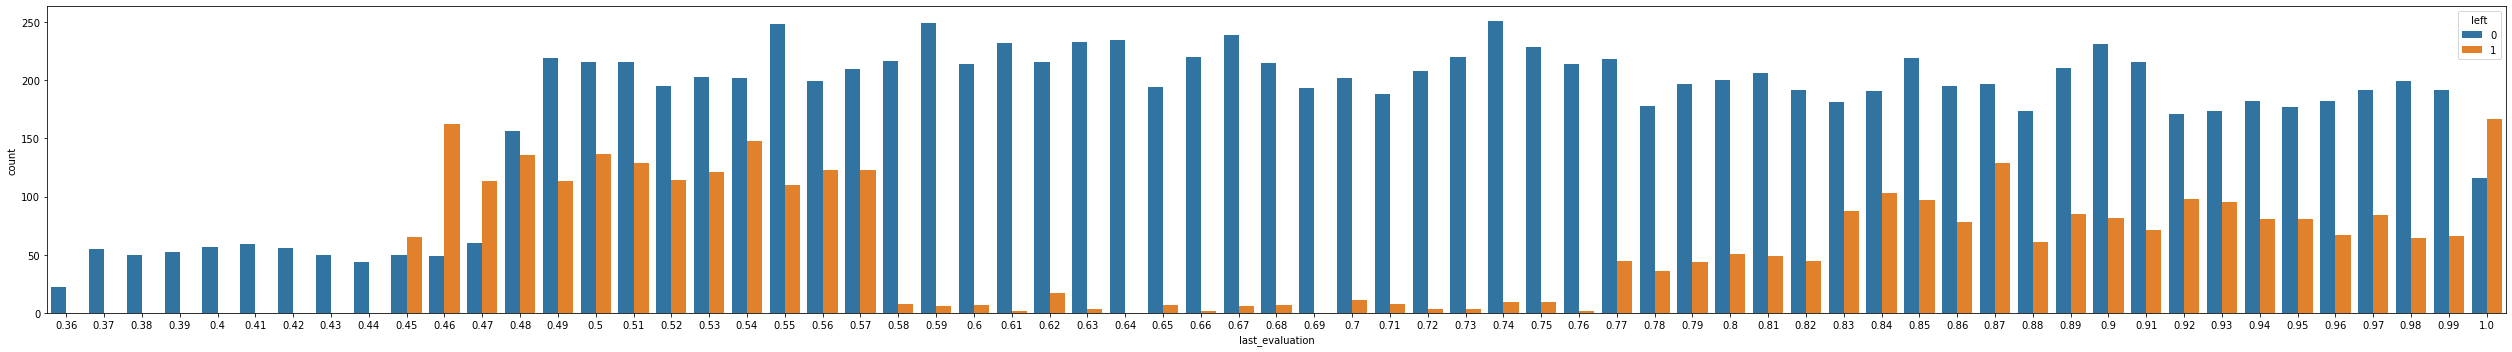

In [15]:
# Turnover by last evaluaction
plt.figure(figsize=(35,5))
sns.countplot(x='last_evaluation', hue='left', data=hr)
plt.tight_layout()

There are two regions in last evaluations with high turnover count: 0.45-0.57, and > 0.77, indicating employees with medium and high evaluations tend to leave. The reason could be better oppotunities in other places.

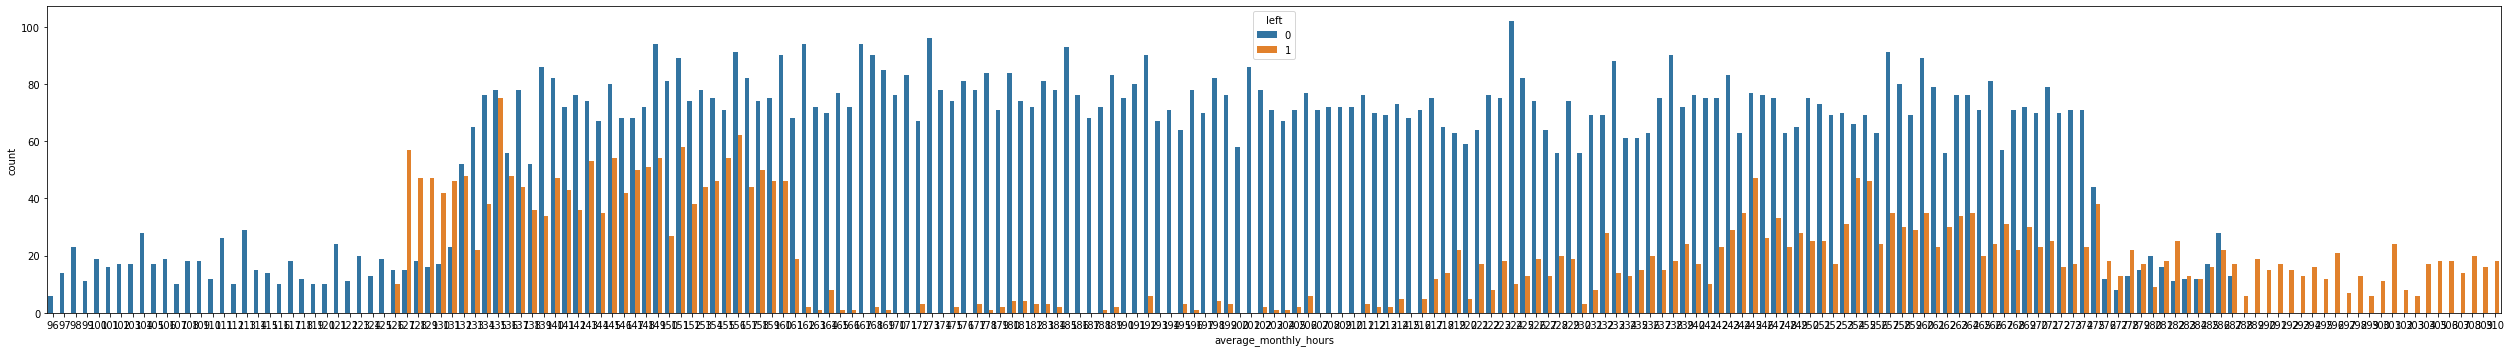

In [16]:
# Turnover by average monthly hours
plt.figure(figsize=(35,5))
sns.countplot(x='average_monthly_hours', hue='left', data=hr)
plt.tight_layout()

There are two high turnover regions in average monthly hours: 126-161 and > 275. For average monthly hours more than 288, turnover rate is 100%.  
Employees with really lower working hours < 125 tend to stay in the company, whereas employees with long working hours >275 have high probability to leave the company. A safe range seems like between 161 to 217 hours, which is ideal for keeping employees in the company.

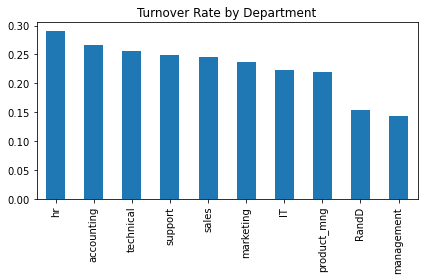

In [17]:
# Turnover by department
hr.groupby('Department')['left'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Turnover Rate by Department')
plt.xlabel('')
plt.tight_layout()

Turnover rate varies depending on the department, but no obvious outlier detected.
HR department has the highest turnover rate.
R&D and Management have significantly lower turnover rate.

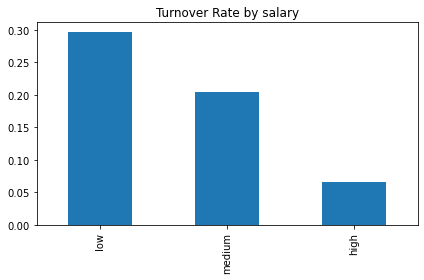

In [18]:
# Turnover by salary
hr.groupby('salary')['left'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Turnover Rate by salary')
plt.xlabel('')
plt.tight_layout()

Salary level has a great impact in the turnover rate. Higher salaries tend to stay in the company(7%), while lower salaries tend to leave the company(30%). 

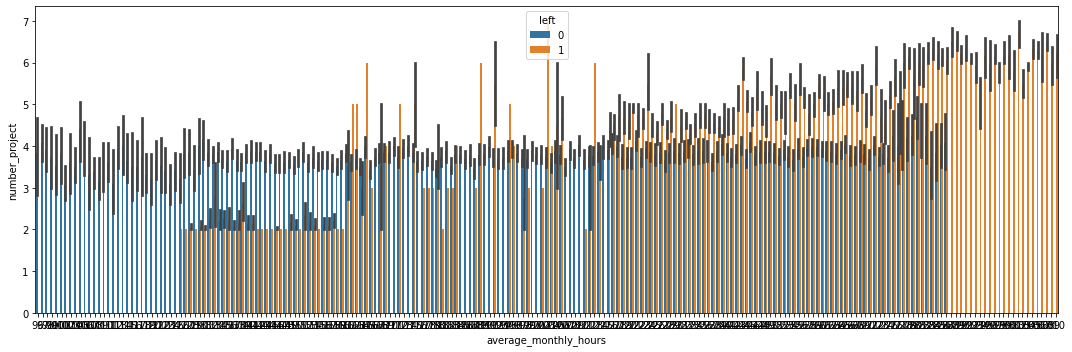

In [19]:
# Number of projects vs Average Monthly Hours
# Barplot with leave values
plt.figure(figsize=(15,5))
sns.barplot(x='average_monthly_hours',y='number_project',hue='left',data=hr)
plt.tight_layout()

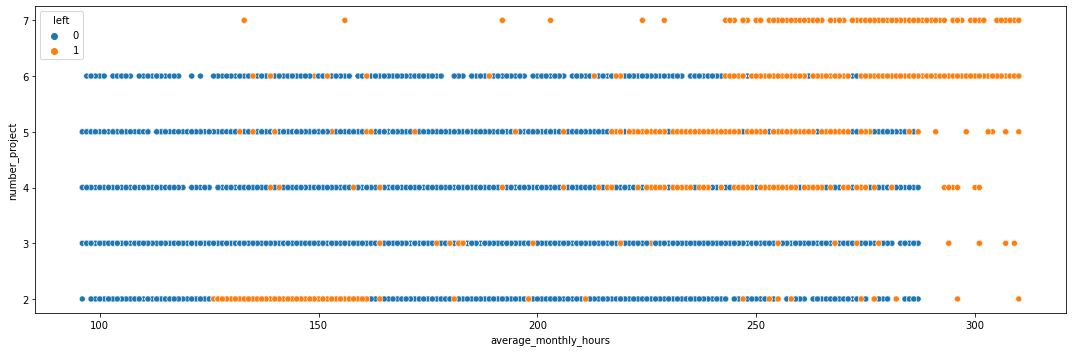

In [20]:
# Scatter plot with left values
plt.figure(figsize=(15,5))
sns.scatterplot(x='average_monthly_hours',y='number_project',hue='left',data=hr)
plt.tight_layout()

Employees with more than 4 projects and working more than 217 hours tend to leave the company.  
Employees with less than 3 projects and working less than 161 hours tend to leave the company.  
A high or low workload seems to push employees out.

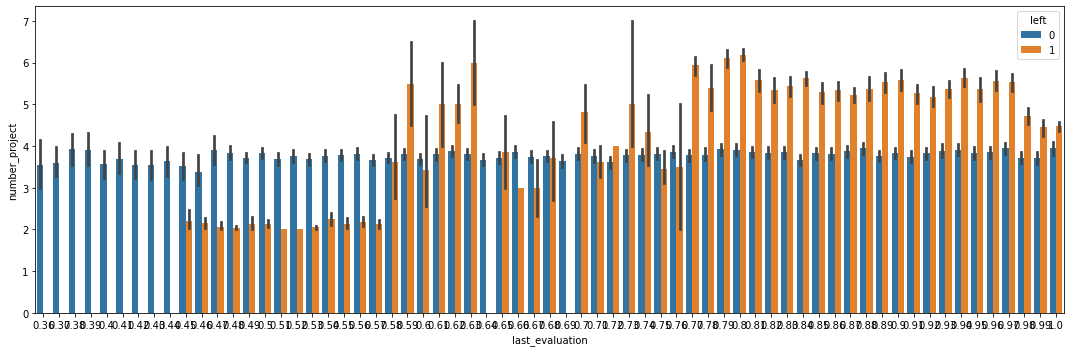

In [21]:
# Number of Projects vs Last Evaluation
# Barplot with leave values
plt.figure(figsize=(15,5))
sns.barplot(x='last_evaluation',y='number_project',hue='left',data=hr)
plt.tight_layout()

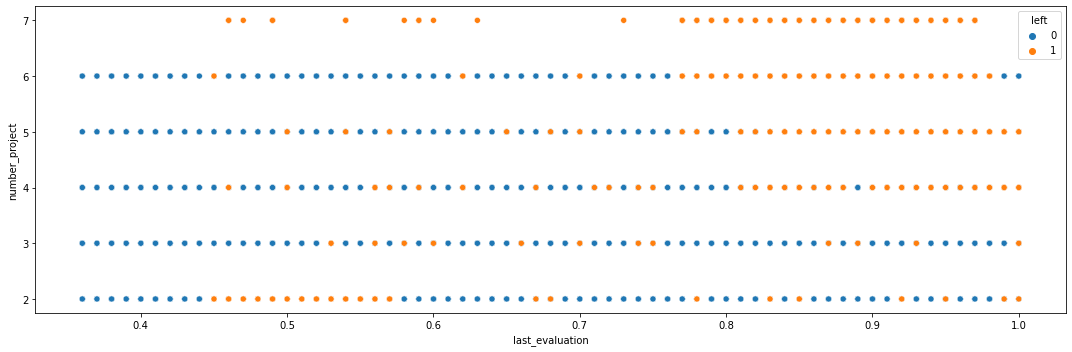

In [22]:
# Scatter plot with left values
plt.figure(figsize=(15,5))
sns.scatterplot(x='last_evaluation',y='number_project',hue='left',data=hr)
plt.tight_layout()

Employees with more than 4 projects and high evaluation tend to leave the company. Same applied to employees with two projects and low evaluation.

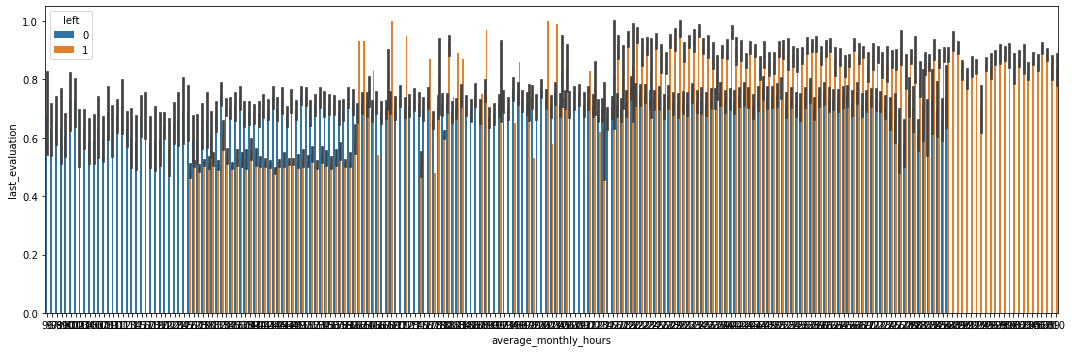

In [23]:
# Last Evaluation vs Average Monthly Hours
plt.figure(figsize=(15,5))
sns.barplot(x='average_monthly_hours',y='last_evaluation',hue='left',data=hr)
plt.tight_layout()

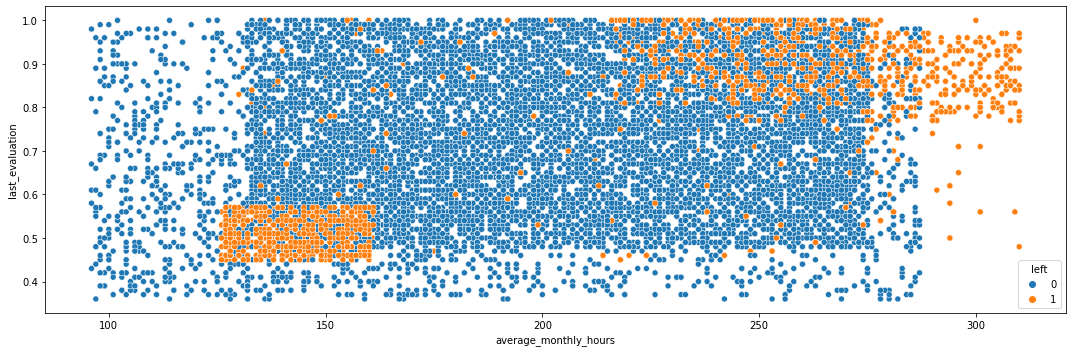

In [24]:
# Scatter plot with left values
plt.figure(figsize=(15,5))
sns.scatterplot(x='average_monthly_hours',y='last_evaluation',hue='left',data=hr)
plt.tight_layout()

Employees with high evaluation and more than 217 hours tend to leave the company. Employees with evaluation around 0.5 and work between 125 and 161 hours tend to leave the company.

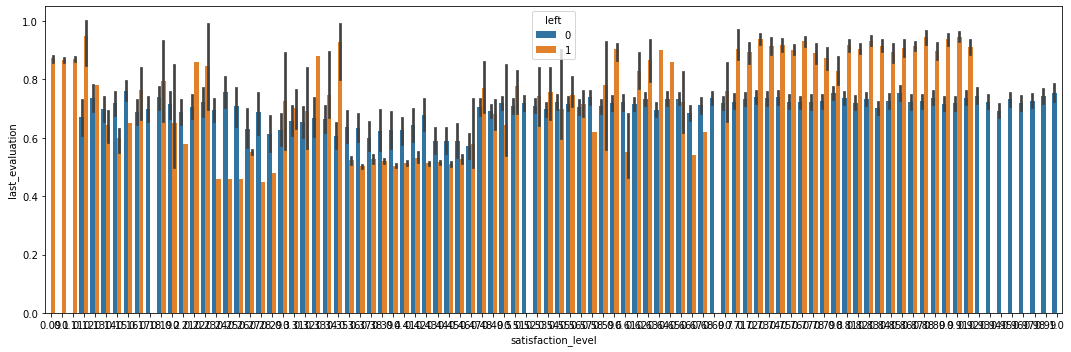

In [25]:
# Last Evaluation vs Satisfaction Level
plt.figure(figsize=(15,5))
sns.barplot(x='satisfaction_level',y='last_evaluation',hue='left',data=hr)
plt.tight_layout()

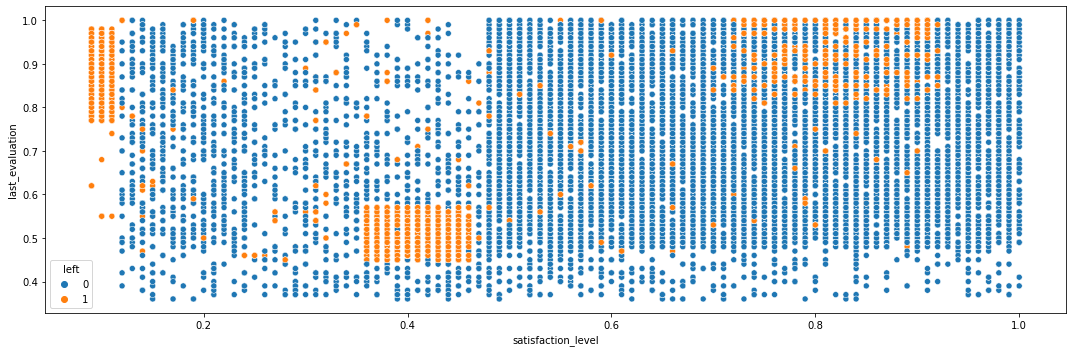

In [26]:
# Scatter plot with left values
plt.figure(figsize=(15,5))
sns.scatterplot(x='satisfaction_level',y='last_evaluation',hue='left',data=hr)
plt.tight_layout()

Employees with satisfaction level below 0.11 tend to leave the company. Employees with satisfaction level between 0.35 and 0.46 and with last evaluation between 0.44 and 0.57 tend to leave. Employees with satisfaction level between 0.71 and 0.92 and with last evaluation between 0.76 and 1 tend to leave

Encoding Categorical Variables

The variable 'Salary' will be encoded using ordinal encoding and 'Department' with one-hot encoding.

In [27]:
# Encoding Salary
salary_dict = {'low': 0, 'medium': 1, 'high': 2}
hr['salary_num'] = hr.salary.map(salary_dict)
hr.drop('salary', inplace=True, axis=1)
hr = hr.rename(columns={'salary_num': 'salary'})
hr.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,0
1,0.80,0.86,5,262,6,0,1,0,sales,1
2,0.11,0.88,7,272,4,0,1,0,sales,1
3,0.72,0.87,5,223,5,0,1,0,sales,0
4,0.37,0.52,2,159,3,0,1,0,sales,0


In [28]:
# Encoding Department
cat_feats = ['Department']
final_data = pd.get_dummies(hr, columns=cat_feats)
#final_data.info()
final_data.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Scaling and Screwness

Numerical variables average_monthly_hours, last_evaluation and satisfaction_level are scaled to remove any influence of their difference in value ranges on the model.

In [29]:
scaler = preprocessing.MinMaxScaler()
hr_scaled = scaler.fit_transform(final_data[['satisfaction_level','last_evaluation','average_monthly_hours']])
hr_scaled = pd.DataFrame(hr_scaled, columns=list(['satisfaction_level','last_evaluation','average_monthly_hours']))

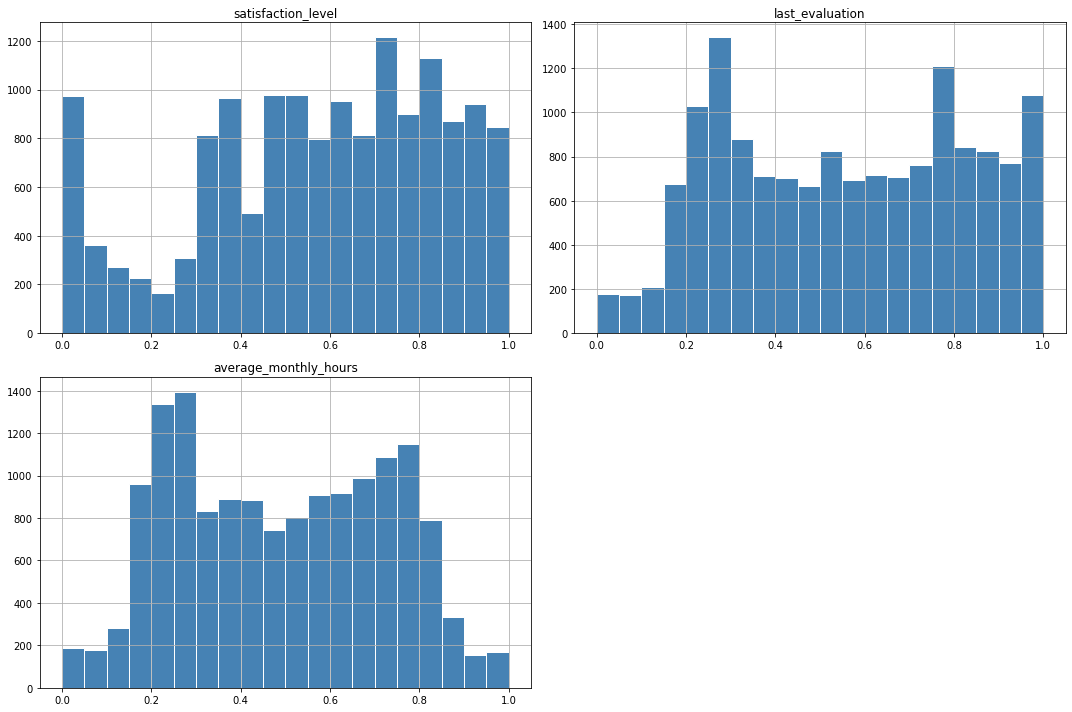

In [30]:
hr_scaled[['satisfaction_level',
                'last_evaluation',
                'average_monthly_hours']].hist(bins = 20, figsize = (15,10), color = 'steelblue', edgecolor='white')
plt.tight_layout()

In [31]:
hr_scaled.describe()

,satisfaction_level,last_evaluation,average_monthly_hours
count,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,0.490889
std,0.273220,0.267452,0.233379
min,0.000000,0.000000,0.000000
25%,0.384615,0.312500,0.280374
50%,0.604396,0.562500,0.485981
75%,0.802198,0.796875,0.696262
max,1.000000,1.000000,1.000000


Fix skewness

In [32]:
def feature_skewness(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: x.skew()).sort_values(ascending=False)
    skews = pd.DataFrame({'skewness':feature_skew})
    return feature_skew, numeric_features

In [33]:
def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: x.skew()).sort_values(ascending=False)
    skews = pd.DataFrame({'skewness':skew_features})
    return df

In [34]:
hr_skewed = fix_skewness(hr_scaled)

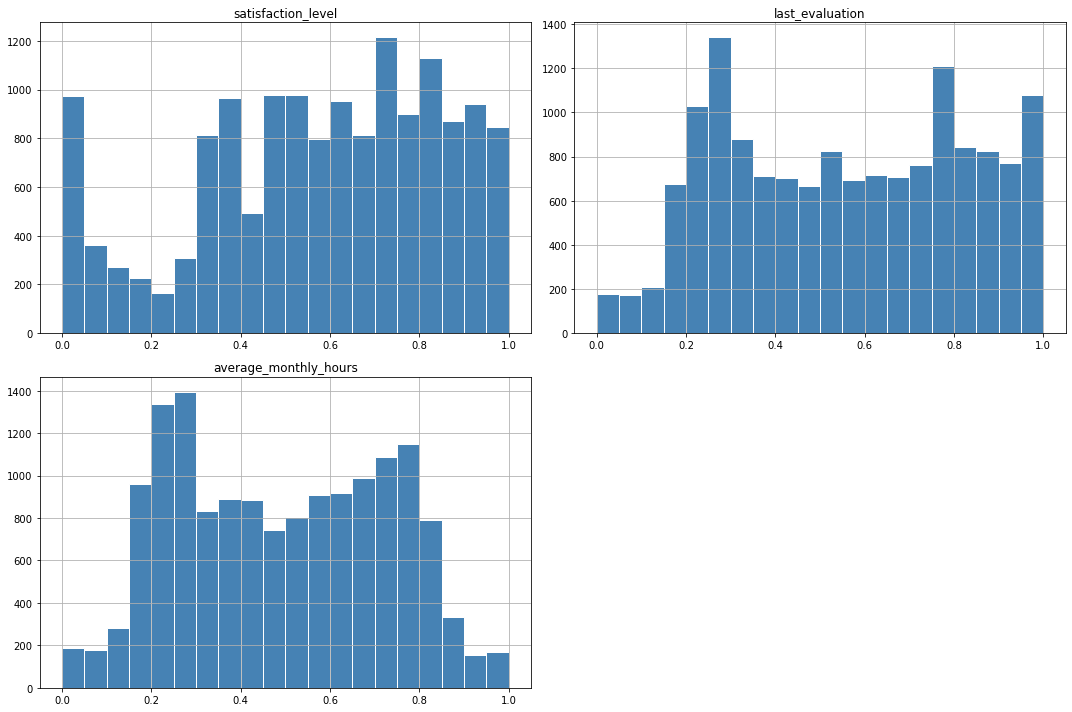

In [35]:
hr_skewed[['satisfaction_level',
                'last_evaluation',
                'average_monthly_hours']].hist(bins = 20, figsize = (15,10), color = 'steelblue', edgecolor='white')
plt.tight_layout()

In [36]:
hr_skewed.describe()

,satisfaction_level,last_evaluation,average_monthly_hours
count,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,0.490889
std,0.273220,0.267452,0.233379
min,0.000000,0.000000,0.000000
25%,0.384615,0.312500,0.280374
50%,0.604396,0.562500,0.485981
75%,0.802198,0.796875,0.696262
max,1.000000,1.000000,1.000000


The resulting values aren't different than the initial ones, showing that the data wasn't skewed.

In [37]:
hr_simple = final_data.copy()
hr_simple.drop(['satisfaction_level',
                'last_evaluation',
                'average_monthly_hours'], inplace=True, axis=1)

hr_ready = pd.DataFrame()
hr_simple.reset_index(drop=True, inplace=True)
hr_skewed.reset_index(drop=True, inplace=True)

hr_ready = pd.concat([hr_skewed,hr_simple], axis=1, sort=False, ignore_index=False)


hr_ready.head()

,satisfaction_level,last_evaluation,average_monthly_hours,number_project,time_spend_company,Work_accident,left,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical
0,0.318681,0.265625,0.285047,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.780220,0.781250,0.775701,5,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.021978,0.812500,0.822430,7,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.692308,0.796875,0.593458,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.307692,0.250000,0.294393,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [38]:
hr_ready.describe()

,satisfaction_level,last_evaluation,average_monthly_hours,number_project,time_spend_company,Work_accident,left,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,0.490889,3.803054,3.498233,0.144610,0.238083,0.021268,0.594706,0.081805,0.052470,0.051137,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345
std,0.273220,0.267452,0.233379,1.232592,1.460136,0.351719,0.425924,0.144281,0.637183,0.274077,0.222981,0.220284,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317
min,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.384615,0.312500,0.280374,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.604396,0.562500,0.485981,4.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.802198,0.796875,0.696262,5.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,7.000000,10.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


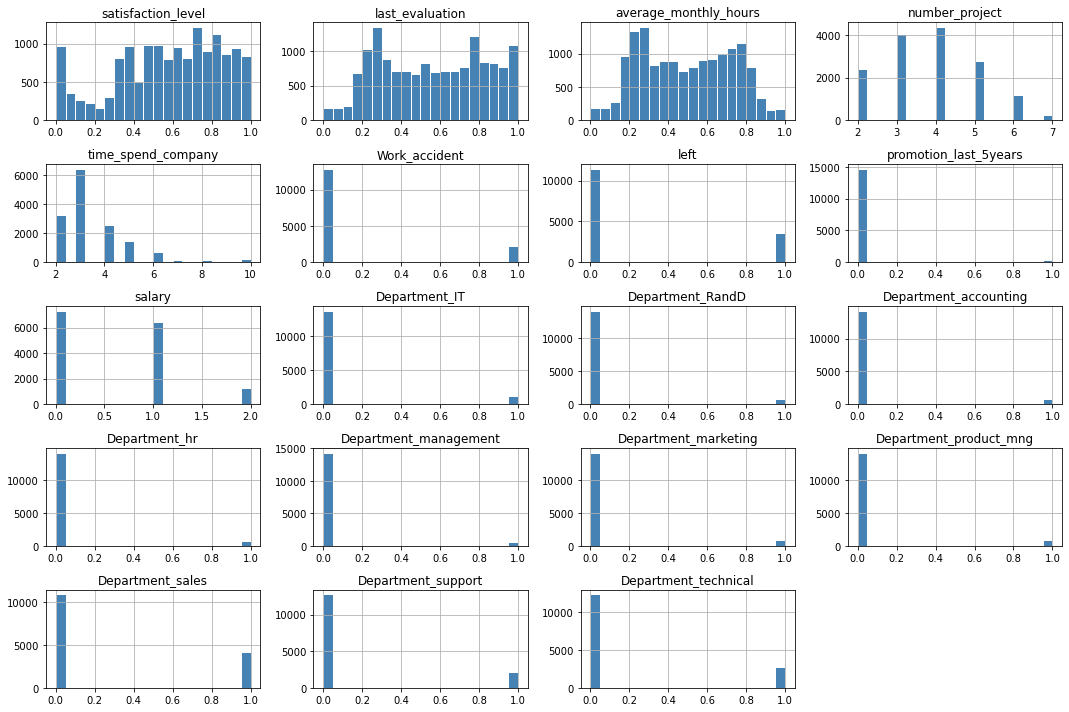

In [39]:
hr_ready.hist(bins = 20, figsize = (15,10), color = 'steelblue', edgecolor='white')
plt.tight_layout()

Training/Test Split

In [40]:
target = 'left'

split_ratio = 0.3
seed = 806

def split_dataset(df, target, split_ratio=0.3, seed=806):
    features = list(df)
    features.remove(target)
    
    X = df[features]
    y = df[[target]]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_ratio, random_state = seed)
    
    return X, y, X_train, X_test, y_train, y_test

X, y, X_train, X_test, y_train, y_test = split_dataset(hr_ready, target, split_ratio, seed)

print('Features:', X.shape[0], 'items | ', X.shape[1], 'columns')
print('Target:', X.shape[0], 'items | ', X.shape[1], 'columns')
print('Features Train:', X_train.shape[0], 'items | ', X_train.shape[1], 'columns')
print('Features Test:', X_test.shape[0], 'items | ', X_test.shape[1], 'columns')
print('Target Train:', y_train.shape[0], 'items | ', y_train.shape[1], 'columns')
print('Target Test:', y_test.shape[0], 'items | ', y_test.shape[1], 'columns')

Features: 14999 items |  18 columns
Target: 14999 items |  18 columns
Features Train: 10499 items |  18 columns
Features Test: 4500 items |  18 columns
Target Train: 10499 items |  1 columns
Target Test: 4500 items |  1 columns


Logistic Regression Model

In [41]:
lr = LogisticRegression(solver = 'lbfgs', max_iter = 300)

In [42]:
def lr_run(model, X_train, X_test, y_train, y_test):
    result = model.fit(X_train, y_train.values.ravel())
    
    y_pred = model.predict(X_test)
    
    acc_test = model.score(X_test, y_test)
    
    coefficients = pd.concat([pd.DataFrame(X_train.columns, columns=['Feature']), pd.DataFrame(np.transpose(model.coef_), columns=['Coef.'])], axis = 1)
    coefficients.loc[-1] = ['intercept.', model.intercept_[0]]
    coefficients.index = coefficients.index + 1
    coefficients = coefficients.sort_index()
    
    print('Accuracy on test:{:.3f}'.format(acc_test))
    print('\n')
    print(classification_report(y_test, y_pred))
    print('\n')
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('\n')
    print(coefficients)

In [43]:
lr_run(lr, X_train, X_test, y_train, y_test)

Accuracy on test:0.797


              precision    recall  f1-score   support

           0       0.82      0.94      0.88      3435
           1       0.63      0.34      0.44      1065

    accuracy                           0.80      4500
   macro avg       0.73      0.64      0.66      4500
weighted avg       0.78      0.80      0.77      4500



Confusion Matrix:
[[3220  215]
 [ 700  365]]


                   Feature     Coef.
0               intercept.  0.655178
1       satisfaction_level -3.617668
2          last_evaluation  0.439433
3    average_monthly_hours  0.910720
4           number_project -0.285436
5       time_spend_company  0.245407
6            Work_accident -1.395113
7    promotion_last_5years -1.192501
8                   salary -0.695676
9            Department_IT -0.067895
10        Department_RandD -0.475129
11   Department_accounting  0.068058
12           Department_hr  0.334216
13   Department_management -0.353498
14    Department_marketing  0.060789
15  Dep

Plot the ROC curve

In [44]:
def plot_roc(model, X_test, y_test):
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show();

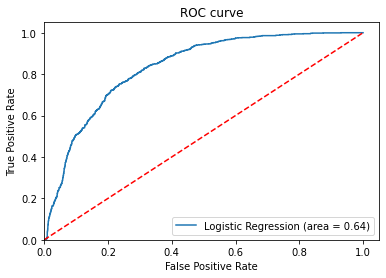

In [45]:
plot_roc(lr, X_test, y_test)

Feature Engineering

Cross Validation Strategy

The model is validated using a 10-fold validation and returning the average accuracy.

In [46]:
def cv_acc (model, X_train, y_train, n_splits, seed):
    kfold = KFold(n_splits=n_splits, shuffle=True)
    scoring = 'accuracy'
    results = cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring=scoring)
    print("10-fold cross validation average accuracy: %.3f" % (results.mean()))
    print()
    for i in range(len(results)):
        print('Iteration', '{:>2}'.format(i+1), '| Accuracy: {:.2f}'.format(results[i]))

In [47]:
cv_acc(lr, X_train, y_train,10, seed)

10-fold cross validation average accuracy: 0.790

Iteration  1 | Accuracy: 0.79
Iteration  2 | Accuracy: 0.81
Iteration  3 | Accuracy: 0.80
Iteration  4 | Accuracy: 0.78
Iteration  5 | Accuracy: 0.79
Iteration  6 | Accuracy: 0.79
Iteration  7 | Accuracy: 0.79
Iteration  8 | Accuracy: 0.76
Iteration  9 | Accuracy: 0.79
Iteration 10 | Accuracy: 0.79


Feature Constrution

The dataset is copied to add or modify features.

In [48]:
hr_fe = hr_ready.copy()

Bin Satisfaction Level

In [49]:
bins = [-1, 0.03, 0.29, 0.41, 0.69, 0.92, 1]
labels=['(0.00, 0.11]','(0.11, 0.35]','(0.35, 0.46]','(0.46, 0.71]','(0.71, 0.92]','(0.92, 1.00]']
hr_fe['satisfaction_level_bin'] = pd.cut(hr_fe.satisfaction_level, bins, labels=labels)
hr_fe.satisfaction_level_bin.value_counts()

(0.71, 0.92]    4765
(0.46, 0.71]    4689
(0.35, 0.46]    2012
(0.92, 1.00]    1362
(0.11, 0.35]    1283
(0.00, 0.11]     888
Name: satisfaction_level_bin, dtype: int64

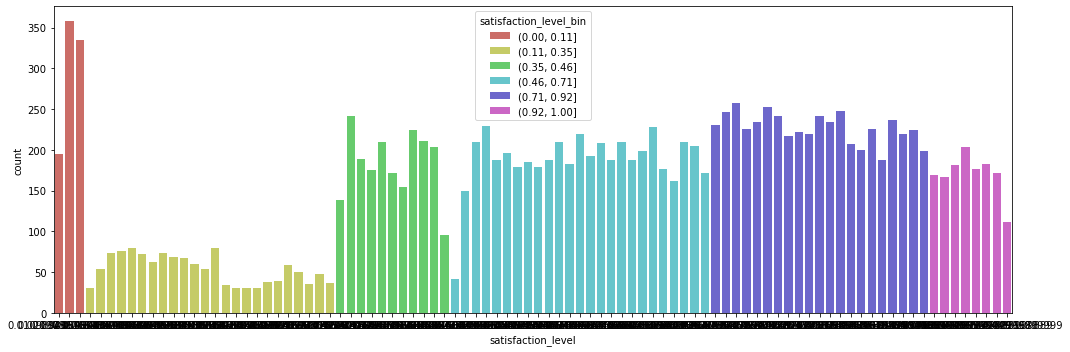

In [50]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe.satisfaction_level,
              hue=hr_fe.satisfaction_level_bin,
              palette = sns.color_palette("hls", 6),
              dodge = False)
plt.tight_layout()

In [51]:
hr_fe_1 = hr_fe.copy()
# Encoding satisfaction_level_bin
cat_feats = ['satisfaction_level_bin']
hr_fe_1 = pd.get_dummies(hr_fe_1, columns=cat_feats)
hr_fe_1.drop('satisfaction_level', inplace=True, axis=1)

In [52]:
X_fe_1, y_fe_1, X_fe_1_train, X_fe_1_test, y_fe_1_train, y_fe_1_test = split_dataset(hr_fe_1, target, split_ratio, seed)

cv_acc(lr, X_fe_1_train, y_fe_1_train, 10, seed)
print()

lr_run(lr, X_fe_1_train, X_fe_1_test, y_fe_1_train,  y_fe_1_test)

10-fold cross validation average accuracy: 0.916

Iteration  1 | Accuracy: 0.92
Iteration  2 | Accuracy: 0.92
Iteration  3 | Accuracy: 0.91
Iteration  4 | Accuracy: 0.91
Iteration  5 | Accuracy: 0.91
Iteration  6 | Accuracy: 0.90
Iteration  7 | Accuracy: 0.92
Iteration  8 | Accuracy: 0.92
Iteration  9 | Accuracy: 0.92
Iteration 10 | Accuracy: 0.92

Accuracy on test:0.913


              precision    recall  f1-score   support

           0       0.94      0.95      0.94      3435
           1       0.83      0.79      0.81      1065

    accuracy                           0.91      4500
   macro avg       0.88      0.87      0.88      4500
weighted avg       0.91      0.91      0.91      4500



Confusion Matrix:
[[3266  169]
 [ 223  842]]


                                Feature     Coef.
0                            intercept. -4.091584
1                       last_evaluation  1.885187
2                 average_monthly_hours  1.871446
3                        number_project -0.11908

Bin Last Evaluation

In [53]:
bins = [-1, 0.14, 0.34, 0.64, 1]
labels=['(0.00, 0.44]','(0.44, 0.57]','(0.57, 0.76]','(0.76, 1.00]']
hr_fe['last_evaluation_bin'] = pd.cut(hr_fe.last_evaluation, bins, labels=labels)
hr_fe_1['last_evaluation_bin'] = pd.cut(hr_fe_1.last_evaluation, bins, labels=labels)
hr_fe_1.last_evaluation_bin.value_counts()

(0.76, 1.00]    6458
(0.57, 0.76]    4279
(0.44, 0.57]    3817
(0.00, 0.44]     445
Name: last_evaluation_bin, dtype: int64

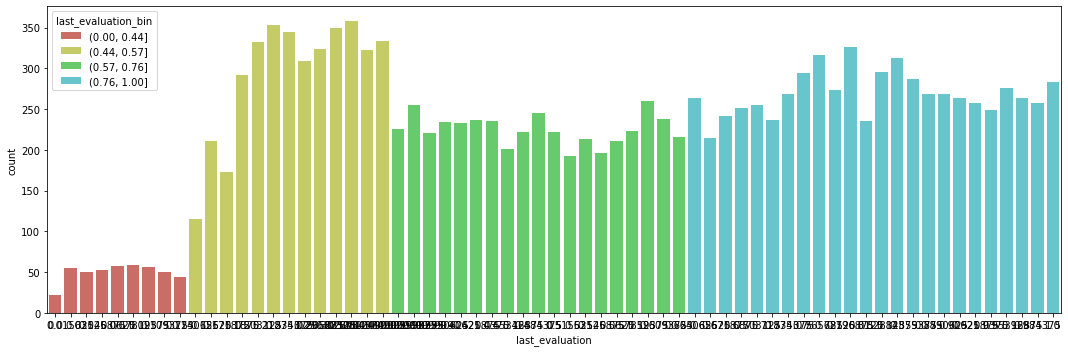

In [54]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_1.last_evaluation,
              hue=hr_fe_1.last_evaluation_bin,
              palette = sns.color_palette("hls", 6),
              dodge = False)
plt.tight_layout()

In [55]:
hr_fe_2 = hr_fe_1.copy()
# Encode last_evaluation_bin
cat_feats = ['last_evaluation_bin']
hr_fe_2 = pd.get_dummies(hr_fe_2, columns=cat_feats)
hr_fe_2.drop('last_evaluation', inplace=True, axis=1)

In [56]:
X_fe_2, y_fe_2, X_fe_2_train, X_fe_2_test, y_fe_2_train, y_fe_2_test = split_dataset(hr_fe_2, target, split_ratio, seed)
cv_acc(lr, X_fe_2_train, y_fe_2_train, 10, seed)
print()
lr_run(lr, X_fe_2_train, X_fe_2_test, y_fe_2_train, y_fe_2_test)

10-fold cross validation average accuracy: 0.934

Iteration  1 | Accuracy: 0.93
Iteration  2 | Accuracy: 0.94
Iteration  3 | Accuracy: 0.93
Iteration  4 | Accuracy: 0.94
Iteration  5 | Accuracy: 0.93
Iteration  6 | Accuracy: 0.93
Iteration  7 | Accuracy: 0.94
Iteration  8 | Accuracy: 0.94
Iteration  9 | Accuracy: 0.93
Iteration 10 | Accuracy: 0.93

Accuracy on test:0.936


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3435
           1       0.88      0.84      0.86      1065

    accuracy                           0.94      4500
   macro avg       0.92      0.90      0.91      4500
weighted avg       0.94      0.94      0.94      4500



Confusion Matrix:
[[3315  120]
 [ 167  898]]


                                Feature     Coef.
0                            intercept. -5.601978
1                 average_monthly_hours  2.192649
2                        number_project  0.058707
3                    time_spend_company  0.46303

Bin Average Monthly Hours

In [57]:
bins = [-1, 0.14, 0.165, 0.304, 0.565, 0.840, 0.897, 1]
labels=['(0, 125]','(125, 131]','(131, 161]','(161, 216]','(216, 274]','(274, 287]','(287, 310]']
hr_fe['average_monthly_hours_bin'] = pd.cut(hr_fe.average_monthly_hours, bins, labels=labels)
hr_fe_2['average_monthly_hours_bin'] = pd.cut(hr_fe_2.average_monthly_hours, bins, labels=labels)
hr_fe_2.average_monthly_hours_bin.value_counts()

(216, 274]    5573
(161, 216]    4290
(131, 161]    3588
(0, 125]       486
(274, 287]     379
(125, 131]     353
(287, 310]     330
Name: average_monthly_hours_bin, dtype: int64

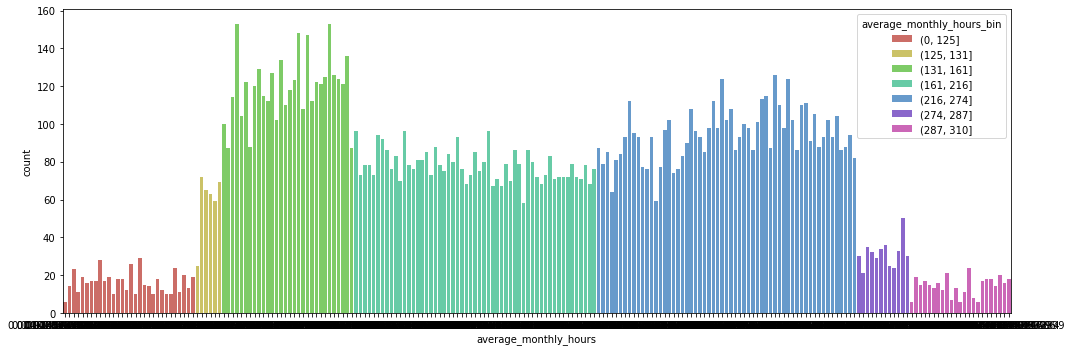

In [58]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_2.average_monthly_hours,
              hue=hr_fe_2.average_monthly_hours_bin,
              palette = sns.color_palette("hls", 7),
              dodge = False)
plt.tight_layout()

In [59]:
hr_fe_3 = hr_fe_2.copy()
hr_fe_3 = pd.get_dummies(hr_fe_3, 'average_monthly_hours')
hr_fe_3.drop('average_monthly_hours', inplace=True, axis=1)

In [60]:
X_fe_3, y_fe_3, X_fe_3_train, X_fe_3_test, y_fe_3_train, y_fe_3_test = split_dataset(hr_fe_3, target, split_ratio, seed)
cv_acc(lr, X_fe_3_train, y_fe_3_train, 10, seed)
print()
lr_run(lr, X_fe_3_train, X_fe_3_test, y_fe_3_train, y_fe_3_test)

10-fold cross validation average accuracy: 0.944

Iteration  1 | Accuracy: 0.94
Iteration  2 | Accuracy: 0.95
Iteration  3 | Accuracy: 0.96
Iteration  4 | Accuracy: 0.95
Iteration  5 | Accuracy: 0.93
Iteration  6 | Accuracy: 0.96
Iteration  7 | Accuracy: 0.94
Iteration  8 | Accuracy: 0.94
Iteration  9 | Accuracy: 0.94
Iteration 10 | Accuracy: 0.93

Accuracy on test:0.945


              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3435
           1       0.91      0.86      0.88      1065

    accuracy                           0.95      4500
   macro avg       0.93      0.92      0.92      4500
weighted avg       0.94      0.95      0.94      4500



Confusion Matrix:
[[3340   95]
 [ 151  914]]


                                Feature     Coef.
0                            intercept. -4.883471
1                        number_project  0.162202
2                    time_spend_company  0.452604
3                         Work_accident -1.15549

Categorize Number of Projects

In [61]:
categ = {2:'too low', 3:'normal', 4:'normal', 5:'normal', 6:'too high', 7:'extreme'}
hr_fe['number_project_cat'] = hr_fe.number_project.map(categ)
hr_fe_3['number_project_cat'] = hr_fe_3.number_project.map(categ)
hr_fe_3.number_project_cat.value_counts()

normal      11181
too low      2388
too high     1174
extreme       256
Name: number_project_cat, dtype: int64

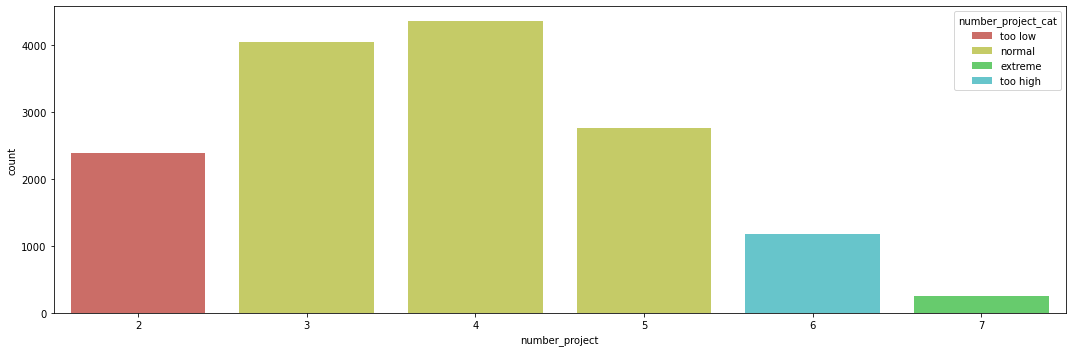

In [62]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_3.number_project,
              hue=hr_fe_3.number_project_cat,
              palette = sns.color_palette("hls", 6),
              dodge = False)
plt.tight_layout()

In [63]:
hr_fe_4 = hr_fe_3.copy()
hr_fe_4 = pd.get_dummies(hr_fe_4,'number_project')
hr_fe_4.drop('number_project', inplace=True, axis=1)

In [64]:
X_fe_4, y_fe_4, X_fe_4_train, X_fe_4_test, y_fe_4_train, y_fe_4_test = split_dataset(hr_fe_4, target, split_ratio, seed)
cv_acc(lr, X_fe_4_train, y_fe_4_train, 10, seed)
print()
lr_run(lr, X_fe_4_train, X_fe_4_test, y_fe_4_train, y_fe_4_test)

10-fold cross validation average accuracy: 0.948

Iteration  1 | Accuracy: 0.96
Iteration  2 | Accuracy: 0.93
Iteration  3 | Accuracy: 0.95
Iteration  4 | Accuracy: 0.94
Iteration  5 | Accuracy: 0.95
Iteration  6 | Accuracy: 0.95
Iteration  7 | Accuracy: 0.95
Iteration  8 | Accuracy: 0.96
Iteration  9 | Accuracy: 0.95
Iteration 10 | Accuracy: 0.94

Accuracy on test:0.950


              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3435
           1       0.90      0.88      0.89      1065

    accuracy                           0.95      4500
   macro avg       0.93      0.93      0.93      4500
weighted avg       0.95      0.95      0.95      4500



Confusion Matrix:
[[3333  102]
 [ 125  940]]


                                Feature     Coef.
0                            intercept. -2.840864
1                    time_spend_company  0.507704
2                         Work_accident -1.201988
3                 promotion_last_5years -0.83780

Categorize Time Spent in Company

In [65]:
categ = {2:'low departure', 3:'high departure', 4:'high departure', 5:'very high departure', 6:'high departure', 7:'no departure', 8:'no departure', 10:'no departure'}
hr_fe['time_spend_company_cat'] = hr_fe.time_spend_company.map(categ)
hr_fe_4['time_spend_company_cat'] = hr_fe_4.time_spend_company.map(categ)
hr_fe_4.time_spend_company_cat.value_counts()

high departure         9718
low departure          3244
very high departure    1473
no departure            564
Name: time_spend_company_cat, dtype: int64

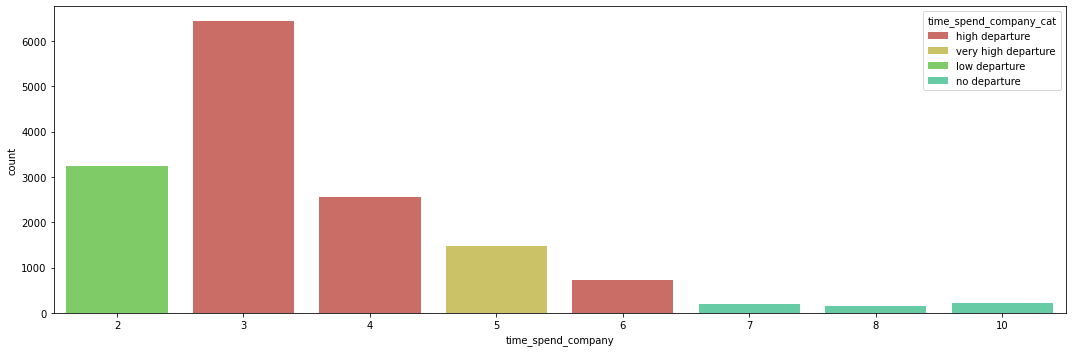

In [66]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_4.time_spend_company,
              hue=hr_fe_4.time_spend_company_cat,
              palette = sns.color_palette("hls", 7),
              dodge = False)
plt.tight_layout()

In [67]:
hr_fe_5 = hr_fe_4.copy()
hr_fe_5 = pd.get_dummies(hr_fe_5, 'time_spend_company')
hr_fe_5.drop('time_spend_company', inplace=True, axis=1)

In [68]:
X_fe_5, y_fe_5, X_fe_5_train, X_fe_5_test, y_fe_5_train, y_fe_5_test = split_dataset(hr_fe_5, target, split_ratio, seed)
cv_acc(lr, X_fe_5_train, y_fe_5_train, 10, seed)
print()
lr_run(lr, X_fe_5_train, X_fe_5_test, y_fe_5_train, y_fe_5_test)

10-fold cross validation average accuracy: 0.955

Iteration  1 | Accuracy: 0.95
Iteration  2 | Accuracy: 0.95
Iteration  3 | Accuracy: 0.95
Iteration  4 | Accuracy: 0.96
Iteration  5 | Accuracy: 0.96
Iteration  6 | Accuracy: 0.95
Iteration  7 | Accuracy: 0.96
Iteration  8 | Accuracy: 0.96
Iteration  9 | Accuracy: 0.97
Iteration 10 | Accuracy: 0.95

Accuracy on test:0.956


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3435
           1       0.93      0.88      0.91      1065

    accuracy                           0.96      4500
   macro avg       0.95      0.93      0.94      4500
weighted avg       0.96      0.96      0.96      4500



Confusion Matrix:
[[3362   73]
 [ 124  941]]


                                   Feature     Coef.
0                               intercept. -1.288513
1                            Work_accident -1.210856
2                    promotion_last_5years -0.454837
3                                   